In [1]:
from __future__ import division

import keras
import numpy as np
import livelossplot
from keras.losses import *
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils import to_categorical
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
# some usefull functions
def tanh(arr):
    # recieves 1D np array
    return np.tanh(arr)

def plot(x, reshape=True):
    if reshape:
        x = x.reshape(28,28)
    plt.imshow(x, cmap='gray')
    plt.show()

def softmax(arr):
     # recieves 1D np array
    scoreMatExp = np.exp(np.asarray(arr))
    return scoreMatExp / scoreMatExp.sum(0)

def predict(inp, weights, layer = 0):
    # given NN, ,akes predictions with cumstom given activations in hidden layers
    weights = weights[layer:]
    for i in range(0, len(weights) - 2, 2):
        inp = tanh(np.dot(inp, weights[i]) + weights[i+1])
    res = softmax(np.dot(inp, weights[-2]) + weights[-1])
    return res

def get_weights(model, layer = 0, bias = False, show_shape = False):
    W, b = model.get_weights()[2*layer:2*layer+2]
    if show_shape:
        print('--------------------------')
        print('W.shape == ', W.shape)
        if bias:
            print('b shape ', b.shape)
        print('--------------------------')
        print()
    
    return (W, b) if bias else W

def get_layer_outputs(x, layer):
    inp = model.input                                        
    out = model.layers[layer].output
    functor = K.function([inp]+ [K.learning_phase()], [out]) 
    
    layer_outs = functor([x, 1.])[0]
    
    return layer_outs

# Experiment 1

### On Random Data
***With tanh activation function I noticed that Feed Forward Neural Networks learn classification tasks by making a  split in each neuron by activating one group of classes with one number and the rest with another. For example with binary classificaiton, samples of one class will activate with a value close to -1 and the other class closer to 1.
To make sure this holds for an arbitrary dataset I decided to test it on the ultimate dataset, the dataset with random imput and output. Of couse anythig the NN "learns" will be artificial patterns, but the dataset can be viewed as an extreemly hard classificaiton data, so can help aviod making conclusions specific to MNIST.***

In [3]:
# Shape can be changed, but with too many rows it will strugle finding patternsin random data 
# and with too little columns it's the same (not enough dimensions to find fake patterns)

num_classes = 2
shape = (100,100)

x = np.random.uniform(-1,1, shape[0]*shape[1]).reshape(shape)
y = np.array([0,1] * (shape[0] // 2))
y_hot = (y == np.array([[1,0]]).T).T * 1

print(x.shape, y.shape, y_hot.shape)

(100, 100) (100,) (100, 2)


***To see the visualization during training open pic.png file form /pics directory***

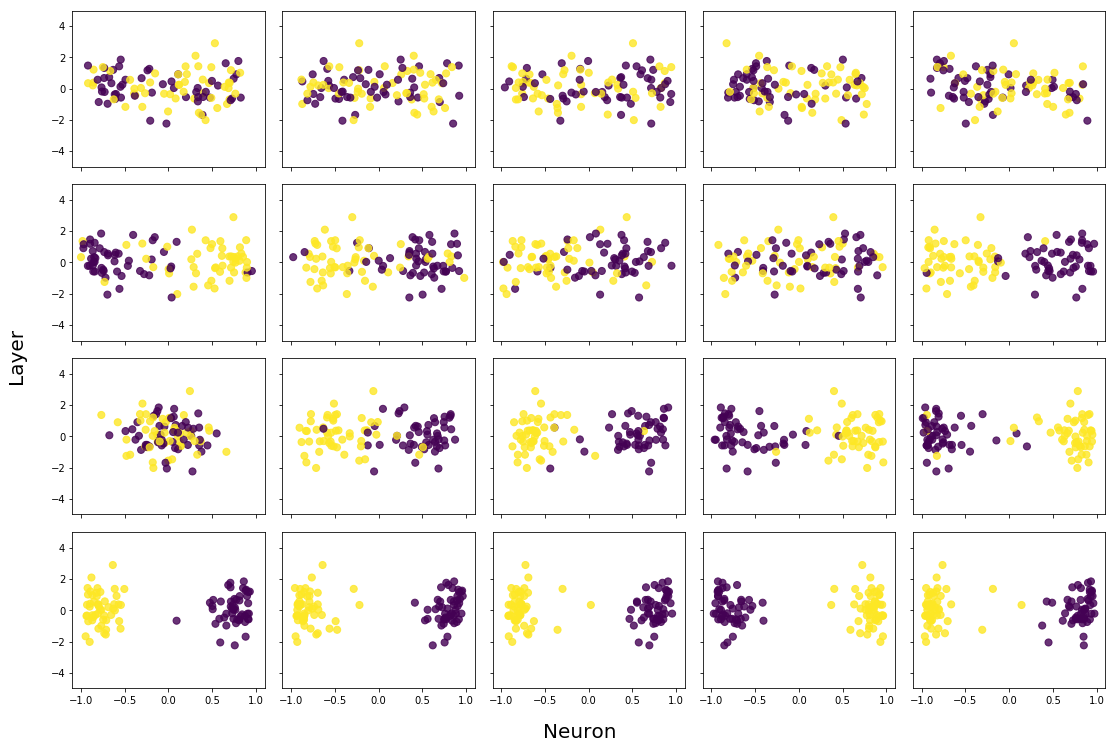

In [4]:
epochs = 10
layers,neurons= 4,5 # how many layers and how manny neurons to visualize

# Let's build a Neural Network to "learn" on our data, and visualize the activations as described above
model = Sequential()
act = activations.tanh
model.add(Dense(input_shape = (shape[1],), units=50, activation=act))
model.add(Dense(10, activation=act))
model.add(Dense(10, activation=act))
model.add(Dense(10, activation=act))
model.add(Dense(num_classes, activation=activations.softmax))

opt = Nadam(2e-4)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

rand = np.random.normal(0,1,shape[0]) # convinient to look at the plot with this

x_int, y_int = 1.5,5 # plot sizes

for epoch in range(epochs): 
    layer_outs = [get_layer_outputs(x, layer=lyr) for lyr in range(layers)]
    
    clear_output(wait=True)
        
    fig, axarr = plt.subplots(nrows=layers, ncols=neurons, sharex=True, sharey=True)
    fig.set_size_inches(15, 10)
    
    fig.text(0.5, -0.03, 'Neuron', fontsize=20, ha='center')
    fig.text(-0.03, 0.5, 'Layer',fontsize=20, va='center', rotation='vertical')
        
    for i in range(layers*neurons):
        act = layer_outs[i//neurons][:,i%neurons]
        
        axarr[i//neurons, i%neurons].set_xlim(-1.1, 1.1)
        axarr[i//neurons, i%neurons].set_ylim(-1*y_int, y_int)     
        axarr[i//neurons, i%neurons].scatter(act, rand,s=50,c=y,alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    model.fit(x, y_hot, epochs=10, batch_size=5, verbose=0, shuffle=True)

### As can be seen, even on random data, NN maneges to split each neurons output to be near -1 for one class and near 1 for the other class. This holds for real datasets line MNIST too. ##

# On MNIST
### First let's try on 2 classes like with random data. Rader can easely check the result for more classes by changing num_classes (see below) and executing the two cells again.

In [5]:
# importing MNIST
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.reshape(60000, 784)/255

x_train.shape, y_train.shape

((60000, 784), (60000,))

In [6]:
# Taking only 2 classes
classes = (0,1)

inds = [y in classes for y in y_train]
x, y = x_train[inds], to_categorical(y_train[inds]).astype(np.int)

x.shape, y.shape

((12665, 784), (12665, 2))

### I use big batch size to slow down the training, so splitting is more gradual and easy to observe

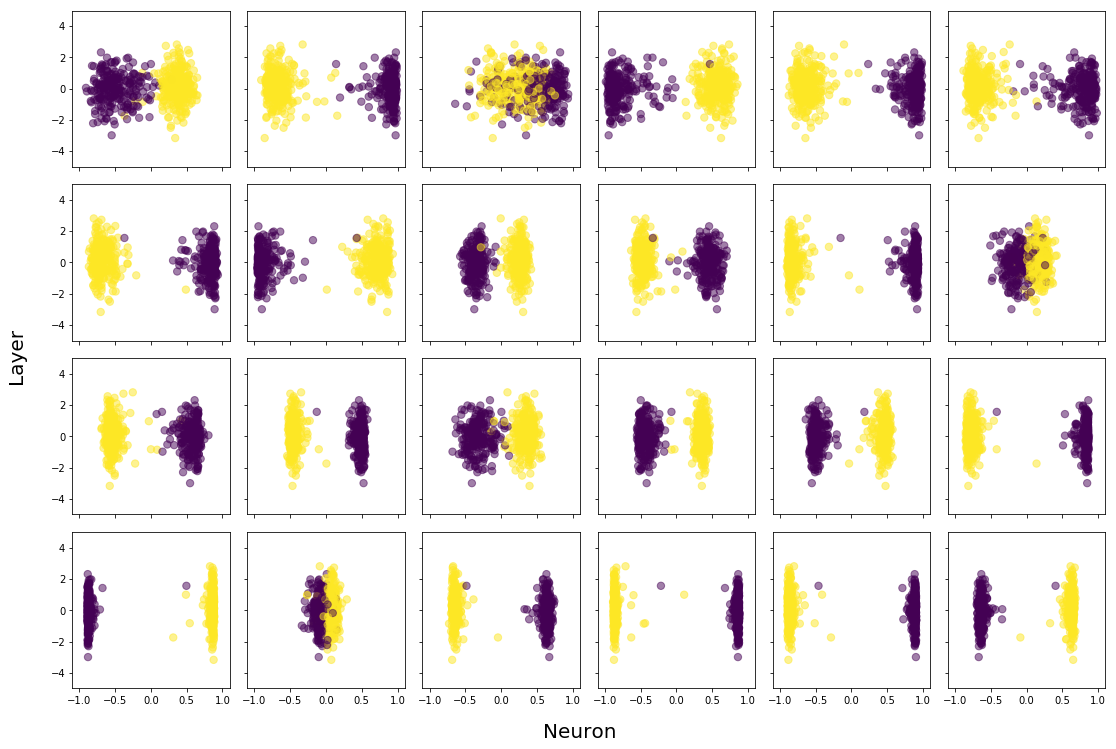

Epoch 1/1
12665/12665 [==============================] - 0s 36us/step - loss: 0.0067 - acc: 0.9988


In [7]:
epochs = 10
layers,neurons= 4, 6 
act = activations.tanh
    
model = Sequential()
model.add(Dense(input_shape = (784,), units=10, activation=act))
model.add(Dense(10, activation=act))
model.add(Dense(10, activation=act))
model.add(Dense(10, activation=act))

model.add(Dense(num_classes, activation=activations.softmax))

opt = SGD()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

inp = model.input   # input placeholder
outputs = [layer.output for layer in model.layers]       
functors = [K.function([inp]+[K.learning_phase()], [out]) for out in outputs]  

rand = np.random.normal(0,1,1000) # convinient to look at the plot with this
x_int, y_int = 1.5,5

for epoch in range(epochs): 
    layer_outs = [get_layer_outputs(x[:500], layer=lyr) for lyr in range(layers)]
    clear_output(wait=True)
    fig, axarr = plt.subplots(nrows=4, ncols=neurons, sharex=True, sharey=True)
    fig.set_size_inches(15, 10)
    
    fig.text(0.5, -0.03, 'Neuron', fontsize=20, ha='center')
    fig.text(-0.03, 0.5, 'Layer',fontsize=20, va='center', rotation='vertical')
   
    
    for i in range(layers*neurons):        
        axarr[i//neurons, i%neurons].set_xlim(-1.1, 1.1)
        axarr[i//neurons, i%neurons].set_ylim(-5, 5)     
        axarr[i//neurons, i%neurons].scatter(x=layer_outs[i//neurons][:,i%neurons],y=rand[:500],s=54,
                                             c=y_train[inds][:500],alpha=0.5)

    plt.tight_layout() 
    plt.show()

    model.fit(x, y, epochs=1, batch_size=50, verbose=1)

# Experiment 2

### First let's train a network

In [16]:
# First train some model
act = activations.tanh

model = Sequential()
model.add(Dense(input_shape = (784,), units=500, activation=act))
model.add(Dense(500, activation=act))
model.add(Dense(500, activation=act))
model.add(Dense(num_classes, activation=activations.softmax))

opt = Nadam(1e-4)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

model.fit(x, y, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12665/12665 [==============================] - 1s 77us/step - loss: 0.0306 - acc: 0.9937
Epoch 2/10
12665/12665 [==============================] - 1s 42us/step - loss: 0.0041 - acc: 0.9990
Epoch 3/10
12665/12665 [==============================] - 1s 43us/step - loss: 0.0029 - acc: 0.9991
Epoch 4/10
12665/12665 [==============================] - 1s 41us/step - loss: 0.0020 - acc: 0.9993
Epoch 5/10
12665/12665 [==============================] - 1s 42us/step - loss: 0.0014 - acc: 0.9994
Epoch 6/10
12665/12665 [==============================] - 1s 42us/step - loss: 9.4726e-04 - acc: 0.9998
Epoch 7/10
12665/12665 [==============================] - 1s 43us/step - loss: 7.2936e-04 - acc: 0.9998
Epoch 8/10
12665/12665 [==============================] - 1s 42us/step - loss: 3.6077e-04 - acc: 1.0000
Epoch 9/10
12665/12665 [==============================] - 1s 42us/step - loss: 2.4128e-04 - acc: 1.0000
Epoch 10/10
12665/12665 [==============================] - 1s 42us/step - loss: 2.02

In [17]:
# then get the signs of activations. 
layer_outs = get_layer_outputs(x[[0]], -2)

sign = np.sign(layer_outs)[0]
print(sign[:15])

[-1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1.]


In [18]:
# probs is the predicted probability of both classes for the given pattern of -1's and 1's at the last hidden layer
probs = []
weights = model.get_weights()

for i in range(len(sign)):
    sign[i] *= -1
    probs.append(predict(inp=sign, weights=weights, layer =-2))
probs = np.array(probs)

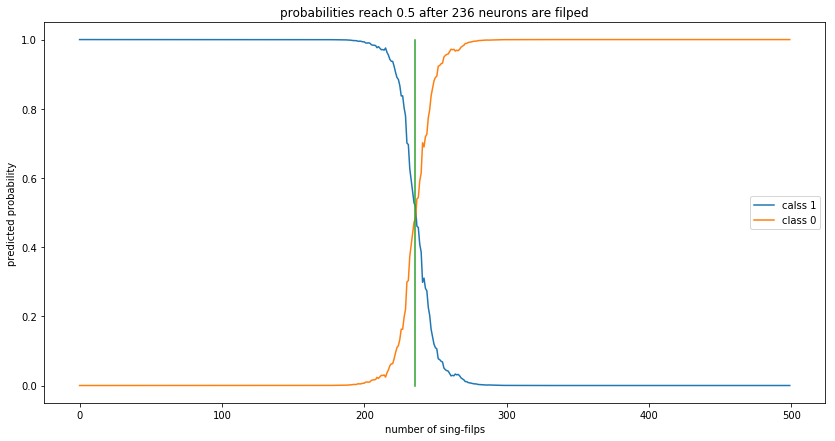

In [19]:
plt.figure(figsize=(14,7))
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])

c = np.argmin(abs(probs[:, 0] - probs[:, 1]))
plt.plot([c, c], [0, 1])

plt.legend(('calss 1', 'class 0'))
plt.title("probabilities reach 0.5 after " + str(c) + " neurons are filped")
plt.xlabel('number of sing-filps')
plt.ylabel('predicted probability')

plt.show()

In [20]:
# probabilities become equal when roughly half of the neurons are flipped
np.argmin(abs(probs[:, 0] - probs[:, 1]))

236

# Experiment 3

### With Logistic Regression

In [21]:
classes = np.arange(10)

inds = [y in classes for y in y_train]
x, y = x_train[inds], to_categorical(y_train[inds]).astype(np.int)

x.shape, y.shape

((60000, 784), (60000, 10))

In [22]:
# Logistic Regression is basically a neural network with no hidden layers
# Training a model
model = Sequential()
act = activations.softmax

model.add(Dense(input_shape = (784,), units=10, activation=act)) # doesn't have a hidden layer

opt = SGD()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

model.fit(x, y, epochs=15, batch_size=100, verbose=1)

Epoch 1/15
60000/60000 [==============================] - 1s 19us/step - loss: 1.1904 - acc: 0.7133
Epoch 2/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.6520 - acc: 0.8490
Epoch 3/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.5415 - acc: 0.8662
Epoch 4/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.4888 - acc: 0.8751
Epoch 5/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.4567 - acc: 0.8812
Epoch 6/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.4344 - acc: 0.8851
Epoch 7/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.4178 - acc: 0.8883
Epoch 8/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.4049 - acc: 0.8910
Epoch 9/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.3944 - acc: 0.8932
Epoch 10/15
60000/60000 [==============================] - 1s 15us/step - loss: 0.3858 - acc: 0.8952

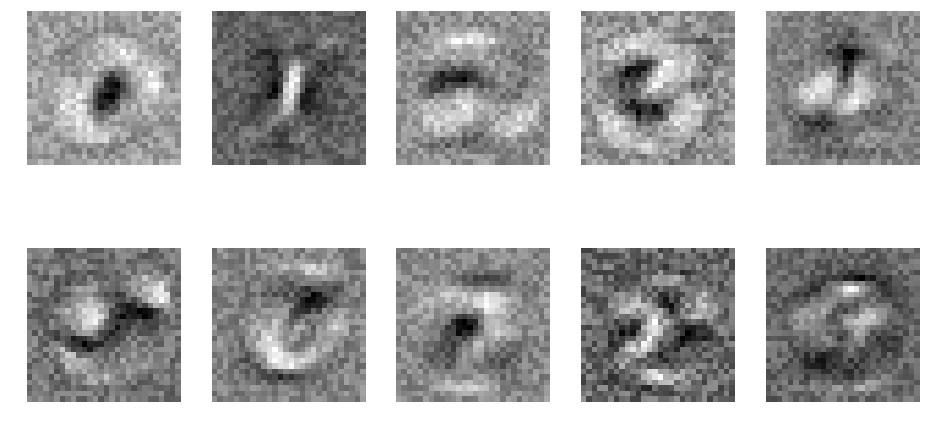

In [23]:
# Vizualizing weights of the first layer
W = get_weights(model, layer=0)

fig, axarr = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(16, 8)

for i in range(10):
    axarr[i//5, i%5].imshow(W[:, i].reshape(28, 28), cmap='gray')
    axarr[i//5, i%5].axis('off')

plt.show()

### But when we do the same for a neural network the pattern dissapears

Epoch 1/5
60000/60000 [==============================] - 4s 67us/step - loss: 0.6367 - acc: 0.8400
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.3221 - acc: 0.9101
Epoch 3/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.2715 - acc: 0.9232
Epoch 4/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.2413 - acc: 0.9311
Epoch 5/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.2180 - acc: 0.9390


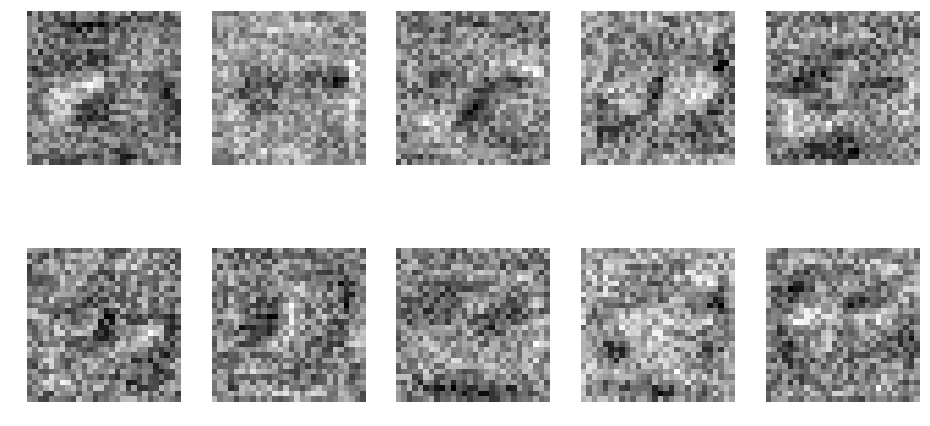

In [24]:
model = Sequential()
act = activations.tanh
model.add(Dense(input_shape = (784,), units=100, activation=act))
model.add(Dense(10, activation=activations.softmax))

opt = Nadam(1e-4)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])

history = model.fit(x, y, epochs=5, batch_size=30, verbose=1)

# Vizualizing weights of the first layer
W = get_weights(model, layer=0)

fig, axarr = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(16, 8)

for i in range(10):
    axarr[i//5, i%5].imshow(W[:, i].reshape(28, 28), cmap='gray')
    axarr[i//5, i%5].axis('off')

plt.show()

#### Weights here look like a random noise, so maybe FFNN are doing something smart and incomprehensible, right? No, they don't. It's just that the pixels that are allways inactive (<200 out of 784 pixels in all MNIST images have values different from 0) don't contribute to loss and their weights don't get updated. On the other hand, little chages in the important weights get optimized with little very modificaitons, so little it's not vizible. To prove this let's make pixel values in images very small (by dividing pixel values by 10000), so the weights have to adapt and get bigger (so that the correspoding dot product activations will get sufficiently far from 0 in case of tanh and 0.5 in case of sigmoid for example)


### To be able to see what's actually going on, let's devide x by a big number, then the weights must change a lot  to accoodate for the smaller input and will expose what realy changes in weights.


## For cleraty of vizualization let's restrict ourselves with 2 classes (pictures of 0's and 1's), though this holds for any number of classes.

In [27]:
# Taking only 2 classes, for example pictures of 0s and 1s
classes = (0,1)

inds = [y in classes for y in y_train]
x, y = x_train[inds]/100000, to_categorical(y_train[inds]).astype(np.int) # importent to devide by alarge number

x.shape, y.shape

((12665, 784), (12665, 2))

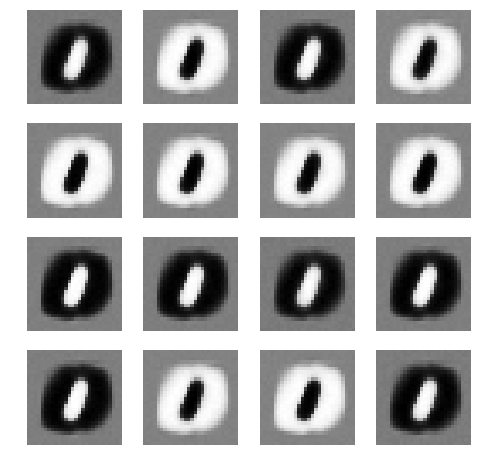

In [29]:
model = Sequential()
act = activations.tanh
model.add(Dense(input_shape = (784,), units=100, activation=act))
model.add(Dense(num_classes, activation=activations.softmax))

opt = Nadam(7e-4)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])

history = model.fit(x, y, epochs=30, batch_size=100, verbose=0)

W = get_weights(model, layer=0)

fig, axarr = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(8, 8)

for i in range(16):
    axarr[i//4, i%4].imshow(W[:, i].reshape(28, 28), cmap = "gray")
    axarr[i//4, i%4].axis('off')

plt.show()

***As you can see it just created a "joint template" for both classes. This looks very similiar to the scatter plot of pixel values above. It's easy to notice that weight matrices differ by sign and (7 with one sign and 9 with another, roughly equall number)***

### Now let's understand how this templates are created
# Experiment 4
***For this experiment we can use all 10 classes. We will vizualize the gradient vector during the training phase, and explain how the templates that we observed above get constructed.***

In [30]:
# Taking only 2 classes, for example pictures of 0s and 1s
classes = range(10)

inds = [y in classes for y in y_train]
x, y = x_train[inds]/255, to_categorical(y_train[inds]).astype(np.int) # importent to devide by alarge number

x.shape, y.shape

((60000, 784), (60000, 10))

In [31]:
act = activations.tanh # can change to any activation funciton to experiment and see that it works for all of them

model = Sequential()
model.add(Dense(input_shape = (784,), units=64, activation=act))
model.add(Dense(64, activation=act))
model.add(Dense(64, activation=act))

model.add(Dense(10, activation=activations.softmax))

opt = SGD(1e-3, momentum = 0)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

model.fit(x,y, epochs=2,batch_size=32, verbose=1)

Epoch 1/2
60000/60000 [==============================] - 4s 59us/step - loss: 2.3016 - acc: 0.1148
Epoch 2/2
60000/60000 [==============================] - 3s 51us/step - loss: 2.3011 - acc: 0.1124


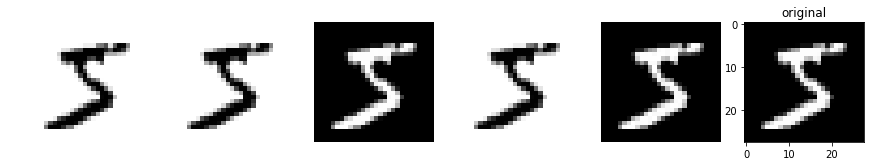

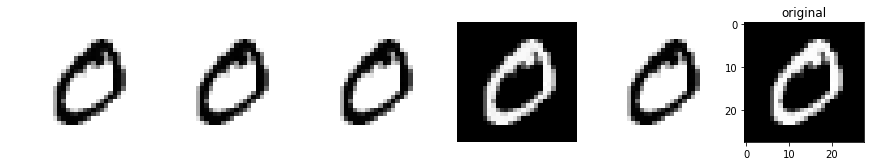

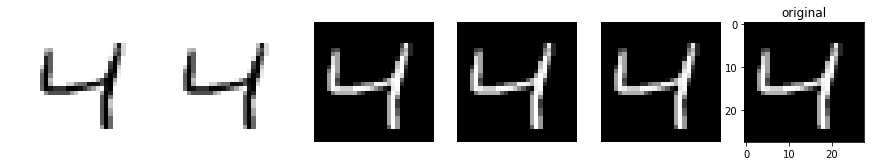

In [32]:
num_plots = 5
num_epochs = 3

W_prev = get_weights(model, layer=0, show_shape=False)
W_prev = W_prev[:, :num_plots]
    
for i in range(num_epochs):
    history = model.fit(x[[i]],y[[i]],epochs=1,batch_size=1, verbose=0)

    W = get_weights(model, layer=0, show_shape=False)
    W = W[:, :num_plots]
    grad = W - W_prev # calculating the gradient
    
    fig, axarr = plt.subplots(nrows=1, ncols = num_plots + 1)
    fig.set_size_inches(15, 5)
    
    for n in range(num_plots):
        axarr[n].imshow(grad[:, n].reshape(28, 28), cmap='gray')
        axarr[n].axis('off')
        
    axarr[-1].imshow(x[[i]].reshape(28, 28), cmap = "gray") # the original image
    plt.title("original")
    plt.show()
    
    W_prev = W

### In hidden layers

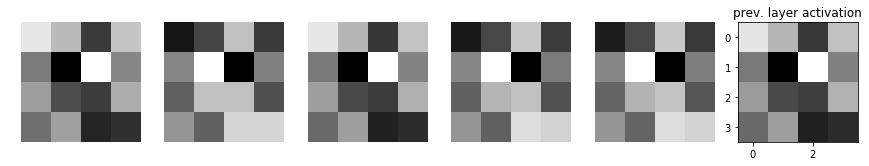

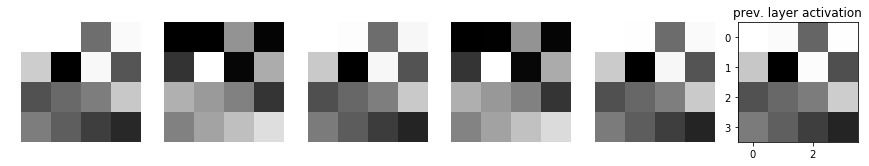

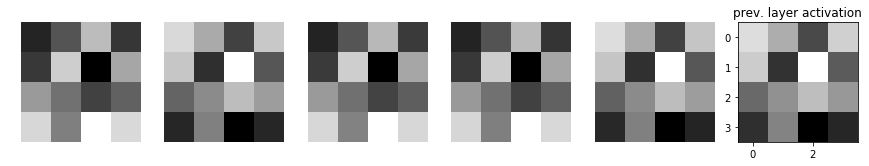

In [39]:
lyr = 1
num_plots = 5
shape = (4, 4)
num_epochs = 3

W_prev = get_weights(model, layer=layer, show_shape=False) # note we take layer 
W_prev = W_prev[:, :num_plots]

for i in range(num_epochs):
    history = model.fit(x[[i]],y[[i]],epochs=1,batch_size=1, verbose=0)

    W = get_weights(model, layer=layer, show_shape=False)
    W = W[:, :num_plots]
    grad = W - W_prev # calculating the gradient
    
    fig, axarr = plt.subplots(nrows=1, ncols = num_plots + 1)
    fig.set_size_inches(15, 5)

    for n in range(num_plots):
        axarr[n].imshow(grad[:, n][:np.prod(shape)].reshape(shape), cmap='gray')
        axarr[n].axis('off')
        
    layer_outs = get_layer_outputs(x[[i]], layer=lyr-1).flatten()

    axarr[-1].imshow(layer_outs[:np.prod(shape)].reshape(shape), cmap = "gray") # the original image
    plt.title("prev. layer activation")
    plt.show()
    
    W_prev = W